### General Imports

In [2]:
import os
import numpy as np
import pandas as pd
import AbstractBaseCollabFilterSGD
from CollabFilterOneVectorPerItem import CollabFilterOneVectorPerItem
from train_valid_test_loader import load_train_valid_test_datasets

### Plotting Imports

In [3]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots 

import seaborn as sns
sns.set('notebook', font_scale=1.0, style='whitegrid')

### Import Data

In [4]:
train_data_tuple, valid_data_tuple, test_data_tuple, total_n_users, total_n_items = load_train_valid_test_datasets()

## Part 1

### Train models for each K

In [5]:
K_candidates = [2, 10, 50]
# K_candidates = [10]

Num_K = len(K_candidates)

models_dict_K = dict()

# Loop over K candidates and train model for each
for K in range(len(K_candidates)):
    curK = K_candidates[K]

    # Init model 
    model = CollabFilterOneVectorPerItem(
        n_factors=curK,
        alpha=0.0,
        batch_size=1000,
        n_epochs=500,
        step_size=0.8,
    )

    model.init_parameter_dict(total_n_users, total_n_items, train_data_tuple)
    model.fit(train_data_tuple, valid_data_tuple)

    models_dict_K[curK] = model

### Plot RMSE vs. Epochs

lowest RMSE on validation set
K=2: 0.9301
K=10: 0.9230
K=50: 0.9191
lowest MAE on validation set
K=2: 0.7311
K=10: 0.7237
K=50: 0.7247


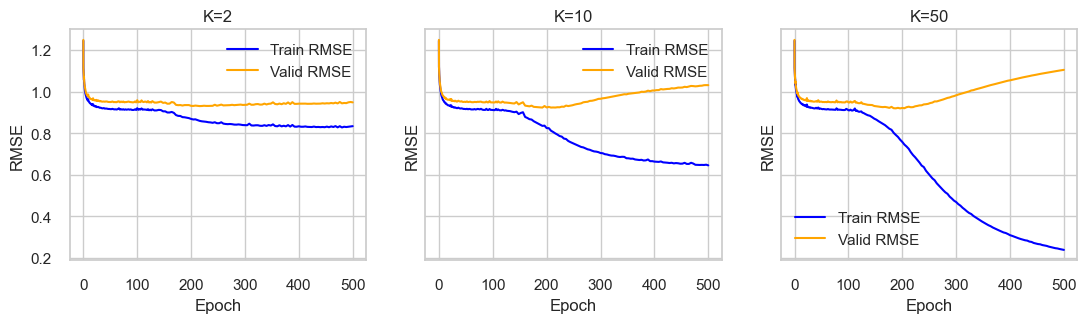

In [6]:
#  Make trace plots showing RMSE vs. epoch when alpha=0
fig, axgrid = plt.subplots(nrows=1, ncols=Num_K, figsize=(4*Num_K+1,3), sharex=True, sharey=True)

# Ensure axgrid is always treated as an array
if Num_K == 1:
    axgrid = [axgrid]

for K in range(len(K_candidates)):
        curK = K_candidates[K]
        model = models_dict_K[curK]
        
        # Plot train and valid RMSE
        axgrid[K].plot(model.trace_epoch, model.trace_rmse_train, label='Train RMSE', color='blue')
        axgrid[K].plot(model.trace_epoch, model.trace_rmse_valid, label='Valid RMSE', color='orange')
        
        # Set title and labels
        axgrid[K].set_title(f'K={curK}')
        axgrid[K].set_xlabel('Epoch')
        axgrid[K].set_ylabel('RMSE')
        axgrid[K].legend()

print("lowest RMSE on validation set")
for K in range(len(K_candidates)):
    curK = K_candidates[K]
    model = models_dict_K[curK]
    print(f"K={curK}: {min(model.trace_rmse_valid):.4f}")

print("lowest MAE on validation set")
for K in range(len(K_candidates)):
    curK = K_candidates[K]
    model = models_dict_K[curK]
    print(f"K={curK}: {min(model.trace_mae_valid):.4f}")


### Early Stopping

In [7]:
# Get the best model for all K with early stopping at the lowest RMSE 
# in the validation set trace by retraining until the best epoch
best_models_early_stopping = dict()
for K in range(len(K_candidates)):
        curK = K_candidates[K]
        model = models_dict_K[curK]
        
        # Get the best epoch
        best_epoch_index = np.argmin(model.trace_rmse_valid)

        # Make new model but stop at the best epoch
        early_stopping_model = CollabFilterOneVectorPerItem(
                n_factors=curK,
                alpha=0.0,
                batch_size=1000,
                n_epochs=int(model.trace_epoch[best_epoch_index]),
                step_size=0.8,
        )

        early_stopping_model.init_parameter_dict(total_n_users, total_n_items, train_data_tuple)
        early_stopping_model.fit(train_data_tuple, valid_data_tuple)

        best_models_early_stopping[curK] = early_stopping_model

### Get testing error

In [8]:
# Find testing RMSE and MAE for the best early stopping models
print("testing RMSE for best early stopping models")
for K in range(len(K_candidates)):
        curK = K_candidates[K]
        model = best_models_early_stopping[curK]

        # Get parameters
        mu = model.param_dict['mu']
        b_per_user = model.param_dict['b_per_user']
        c_per_item = model.param_dict['c_per_item']
        U = model.param_dict['U']
        V = model.param_dict['V']

        # calc RMSE
        predictions = model.predict(test_data_tuple[0], test_data_tuple[1], mu, b_per_user, c_per_item, U, V)
        rmse = np.sqrt(np.mean((predictions - test_data_tuple[2]) ** 2))
        print(f"K={curK}: {rmse:.4f}")

print("testing MAE for best early stopping models")
for K in range(len(K_candidates)):
        curK = K_candidates[K]
        model = best_models_early_stopping[curK]

        # Get parameters
        mu = model.param_dict['mu']
        b_per_user = model.param_dict['b_per_user']
        c_per_item = model.param_dict['c_per_item']
        U = model.param_dict['U']
        V = model.param_dict['V']

        # calc MAE
        predictions = model.predict(test_data_tuple[0], test_data_tuple[1], mu, b_per_user, c_per_item, U, V)
        mae = np.mean(np.abs(predictions - test_data_tuple[2]))
        print(f"K={curK}: {mae:.4f}")

# Make table with RMSE and MAE on training, validation, and testing set for early stopping models

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['K', 'RMSE Train', 'RMSE Valid', 'RMSE Test', 'MAE Train', 'MAE Valid', 'MAE Test'])

for K in range(len(K_candidates)):
    curK = K_candidates[K]
    model = best_models_early_stopping[curK]

    # Get parameters
    mu = model.param_dict['mu']
    b_per_user = model.param_dict['b_per_user']
    c_per_item = model.param_dict['c_per_item']
    U = model.param_dict['U']
    V = model.param_dict['V']

    # Calculate RMSE and MAE for train, valid, and test sets
    rmse_train = np.sqrt(np.mean((model.predict(train_data_tuple[0], train_data_tuple[1], mu, b_per_user, c_per_item, U, V) - train_data_tuple[2]) ** 2))
    rmse_valid = np.sqrt(np.mean((model.predict(valid_data_tuple[0], valid_data_tuple[1], mu, b_per_user, c_per_item, U, V) - valid_data_tuple[2]) ** 2))
    rmse_test = np.sqrt(np.mean((model.predict(test_data_tuple[0], test_data_tuple[1], mu, b_per_user, c_per_item, U, V) - test_data_tuple[2]) ** 2))

    mae_train = np.mean(np.abs(model.predict(train_data_tuple[0], train_data_tuple[1], mu, b_per_user, c_per_item, U, V) - train_data_tuple[2]))
    mae_valid = np.mean(np.abs(model.predict(valid_data_tuple[0], valid_data_tuple[1], mu, b_per_user, c_per_item, U, V) - valid_data_tuple[2]))
    mae_test = np.mean(np.abs(model.predict(test_data_tuple[0], test_data_tuple[1], mu, b_per_user, c_per_item, U, V) - test_data_tuple[2]))

    # add results to DataFrame
    results_df.loc[len(results_df)] = [curK, rmse_train, rmse_valid, rmse_test, mae_train, mae_valid, mae_test]

print("\nResults DataFrame:")
print(results_df)

testing RMSE for best early stopping models
K=2: 0.9314
K=10: 0.9215
K=50: 0.9143
testing MAE for best early stopping models
K=2: 0.7267
K=10: 0.7207
K=50: 0.7152

Results DataFrame:
      K  RMSE Train  RMSE Valid  RMSE Test  MAE Train  MAE Valid  MAE Test
0   2.0     0.85891    0.930068   0.931352   0.676126   0.732255  0.726656
1  10.0     0.83494    0.922990   0.921457   0.657310   0.728151  0.720701
2  50.0     0.76859    0.919074   0.914291   0.603730   0.725335  0.715165


### Train models for various values of alpha

In [9]:
alpha_candidates = [0.05, 0.08, 0.1, 0.2, 0.5]

Num_alpha = len(alpha_candidates)

models_dict_alpha = dict()

# Loop over K candidates and train model for each
for alpha in range(len(alpha_candidates)):
    currAlpha = alpha_candidates[alpha]

    # Init model 
    model = CollabFilterOneVectorPerItem(
        n_factors=50,
        alpha=currAlpha,
        batch_size=1000,
        n_epochs=500,
        step_size=0.8,
    )

    model.init_parameter_dict(total_n_users, total_n_items, train_data_tuple)
    model.fit(train_data_tuple, valid_data_tuple)

    models_dict_alpha[currAlpha] = model

### Plot for each alpha 

lowest RMSE on validation set
alpha=0.05: 0.9176
alpha=0.08: 0.9164
alpha=0.1: 0.9161
alpha=0.2: 0.9205
alpha=0.5: 0.9475
lowest MAE on validation set
alpha=0.05: 0.7213
alpha=0.08: 0.7208
alpha=0.1: 0.7202
alpha=0.2: 0.7239
alpha=0.5: 0.7459


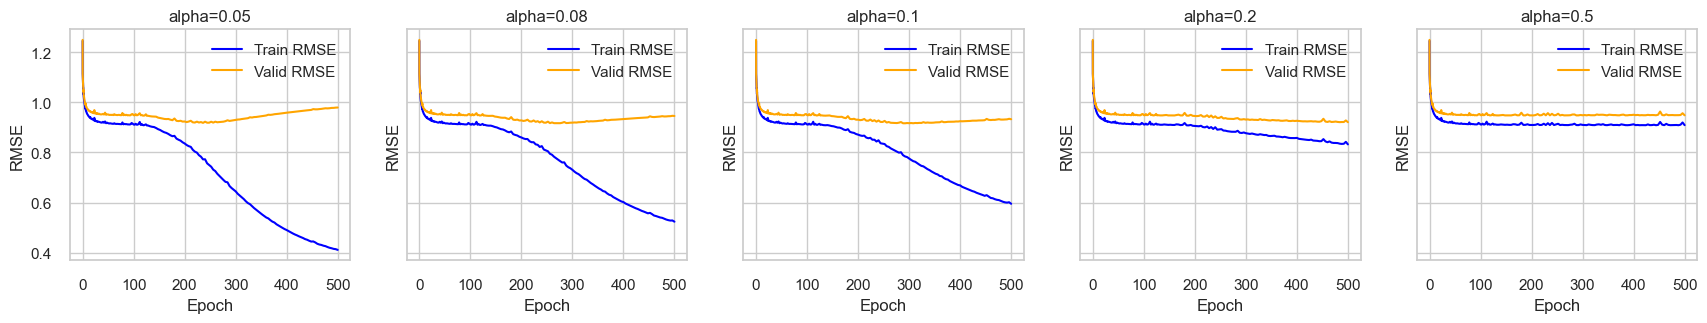

In [10]:
#  Make trace plots showing RMSE vs. epoch when K=50
fig, axgrid = plt.subplots(nrows=1, ncols=Num_alpha, figsize=(4*Num_alpha+1,3), sharex=True, sharey=True)
for alpha in range(len(alpha_candidates)):
        currAlpha = alpha_candidates[alpha]
        model = models_dict_alpha[currAlpha]
        
        # Plot train and valid RMSE
        axgrid[alpha].plot(model.trace_epoch, model.trace_rmse_train, label='Train RMSE', color='blue')
        axgrid[alpha].plot(model.trace_epoch, model.trace_rmse_valid, label='Valid RMSE', color='orange')
        
        # Set title and labels
        axgrid[alpha].set_title(f'alpha={currAlpha}')
        axgrid[alpha].set_xlabel('Epoch')
        axgrid[alpha].set_ylabel('RMSE')
        axgrid[alpha].legend()
        
print("lowest RMSE on validation set")
for alpha in range(len(alpha_candidates)):
    currAlpha = alpha_candidates[alpha]
    model = models_dict_alpha[currAlpha]
    print(f"alpha={currAlpha}: {min(model.trace_rmse_valid):.4f}")

print("lowest MAE on validation set")
for alpha in range(len(alpha_candidates)):
    currAlpha = alpha_candidates[alpha]
    model = models_dict_alpha[currAlpha]
    print(f"alpha={currAlpha}: {min(model.trace_mae_valid):.4f}")

### Plot best alpha

Text(0, 0.5, 'RMSE')

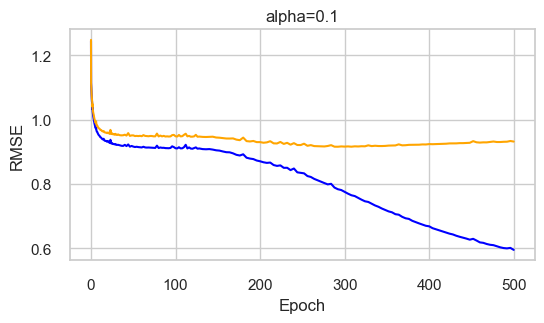

In [11]:
# make trace plot for just alpha=0.1
fig, ax = plt.subplots(figsize=(6,3))
model = models_dict_alpha[0.1]
# Plot train and valid RMSE
ax.plot(model.trace_epoch, model.trace_rmse_train, label='Train RMSE', color='blue')
ax.plot(model.trace_epoch, model.trace_rmse_valid, label='Valid RMSE', color='orange')
# Set title and labels
ax.set_title(f'alpha={0.1}')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')

### Do early stopping for alpha=0.1 and record RMSE/MAE for all sets

In [12]:
model = models_dict_alpha[0.1]

# Get the best epoch
best_epoch_index = np.argmin(model.trace_rmse_valid)

# Make new model but stop at the best epoch
early_stopping_model = CollabFilterOneVectorPerItem(
        n_factors=50,
        alpha=0.1,
        batch_size=1000,
        n_epochs=int(model.trace_epoch[best_epoch_index]),
        step_size=0.8,
)

early_stopping_model.init_parameter_dict(total_n_users, total_n_items, train_data_tuple)
early_stopping_model.fit(train_data_tuple, valid_data_tuple)

# Record Train/Valid/Test RMSE and MAE for alpha=0.1
mu = model.param_dict['mu']
b_per_user = model.param_dict['b_per_user']
c_per_item = model.param_dict['c_per_item']
U = model.param_dict['U']
V = model.param_dict['V']
# calc RMSE
rmse_train = np.sqrt(np.mean((early_stopping_model.predict(train_data_tuple[0], train_data_tuple[1], mu, b_per_user, c_per_item, U, V) - train_data_tuple[2]) ** 2))
rmse_valid = np.sqrt(np.mean((early_stopping_model.predict(valid_data_tuple[0], valid_data_tuple[1], mu, b_per_user, c_per_item, U, V) - valid_data_tuple[2]) ** 2))
rmse_test = np.sqrt(np.mean((early_stopping_model.predict(test_data_tuple[0], test_data_tuple[1], mu, b_per_user, c_per_item, U, V) - test_data_tuple[2]) ** 2))

# calc MAE
mae_train = np.mean(np.abs(early_stopping_model.predict(train_data_tuple[0], train_data_tuple[1], mu, b_per_user, c_per_item, U, V) - train_data_tuple[2]))
mae_valid = np.mean(np.abs(early_stopping_model.predict(valid_data_tuple[0], valid_data_tuple[1], mu, b_per_user, c_per_item, U, V) - valid_data_tuple[2]))
mae_test = np.mean(np.abs(early_stopping_model.predict(test_data_tuple[0], test_data_tuple[1], mu, b_per_user, c_per_item, U, V) - test_data_tuple[2]))

# Create a DataFrame to store the results
results_df_alpha = pd.DataFrame(columns=['alpha', 'RMSE Train', 'RMSE Valid', 'RMSE Test', 'MAE Train', 'MAE Valid', 'MAE Test'])
# add results to DataFrame
results_df_alpha.loc[len(results_df_alpha)] = [0.1, rmse_train, rmse_valid, rmse_test, mae_train, mae_valid, mae_test]
print("\nResults DataFrame for alpha=0.1:")
print(results_df_alpha)


Results DataFrame for alpha=0.1:
   alpha  RMSE Train  RMSE Valid  RMSE Test  MAE Train  MAE Valid  MAE Test
0    0.1    0.594729    0.932981   0.924624   0.467592   0.737357  0.724772


### Scatter Plot for best model at K=2 on selected movies

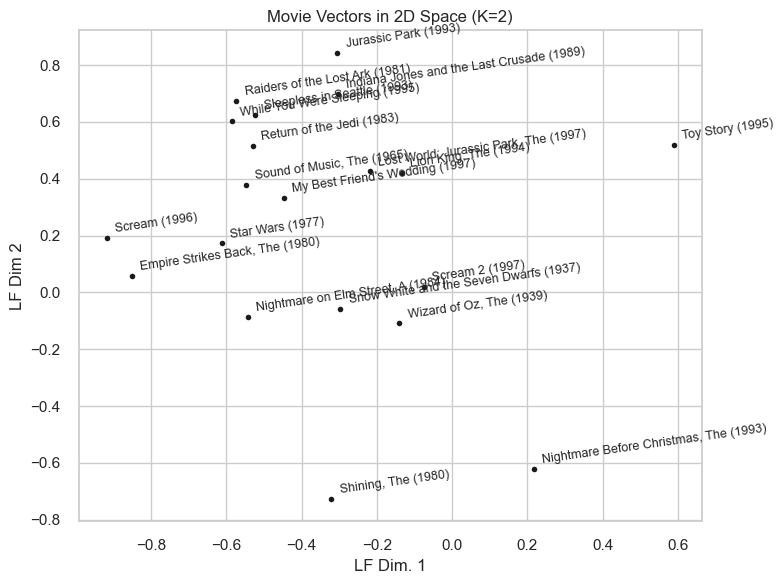

In [27]:
# Figure and caption: For the best LF model with K=2
#  factors, consider the learned per-movie vectors vj
#  for the short list of movies listed in select_movies.csv. Make a scatter plot of the 2-dimensional "embedding" vector vj
#  of these movies (labeling each point with its movie title).

# Load the movie titles
movies_df = pd.read_csv(os.path.join('data_movie_lens_100k', 'select_movies.csv'))
movie_ids = movies_df['item_id'].tolist()
movie_titles = movies_df['title'].tolist()

# Get the movie vectors
model = best_models_early_stopping[2]
selected_movie_vectors = model.param_dict['V'][movie_ids]

# Create a scatter plot of the movie vectors using commented example code above
fig, ax = plt.subplots(figsize=(8, 6))
selected_movie_vectors = selected_movie_vectors[:, :2]  # Use only the first two dimensions for 2D plot

B = 0.02  # Small offset for text positioning

for i, (x, y) in enumerate(selected_movie_vectors):
    # Plot black dot
    ax.plot(x, y, 'k.', markersize=8)

    # Plot rotated text
    ax.text(x + B, y + B, movie_titles[i], rotation=8, fontsize=9)

# Set title and labels
ax.set_title('Movie Vectors in 2D Space (K=2)')
ax.set_xlabel('LF Dim. 1')
ax.set_ylabel('LF Dim 2')
plt.tight_layout()
plt.show()